In [0]:
%tensorflow_version 2.x

In [0]:
import zipfile
zfile = zipfile.ZipFile("drive/My Drive/dog_cat.zip")
zfile.extractall("dataset")

In [3]:
import glob
import pandas as pd
catfn = glob.glob("dataset/train/cat.*")
catans = [0] * len(catfn)
dogfn = glob.glob("dataset/train/dog.*")
dogans = [1] * len(dogfn)
df = pd.DataFrame({
    "path":catfn + dogfn,
    "target":catans + dogans
})
df

,path,target
0,dataset/train/cat.6317.jpg,0
1,dataset/train/cat.1389.jpg,0
2,dataset/train/cat.9962.jpg,0
3,dataset/train/cat.7198.jpg,0
4,dataset/train/cat.3849.jpg,0
...,...,...
24995,dataset/train/dog.3332.jpg,1
24996,dataset/train/dog.11010.jpg,1
24997,dataset/train/dog.9438.jpg,1
24998,dataset/train/dog.7052.jpg,1


(346, 500)


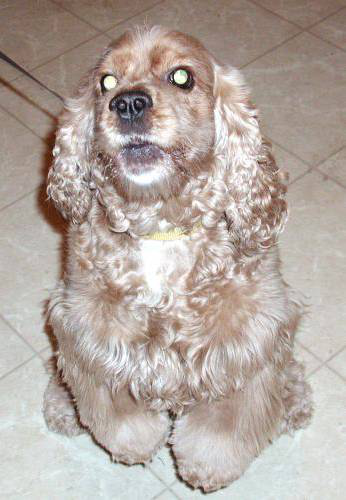

In [4]:
from tensorflow.keras.preprocessing.image import load_img
p = "dataset/train/dog.3014.jpg"
img = load_img(p)
print(img.size)
img

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))
cnn.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
for l in cnn.layers:
    l.trainable = False
x = BatchNormalization()(cnn.output)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
out = Dense(2, activation="softmax")(x)
model = Model(inputs=cnn.input, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

In [0]:
# 好習慣: 全部轉成numpy array
import numpy as np
from sklearn.model_selection import train_test_split
x, y = np.array(df["path"]), np.array(df["target"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [9]:
from tensorflow.keras.applications.vgg16 import preprocess_input
# return value: (原圖, 預處理過圖, 答案)
def dataflow(x, y, BATCH=20):
    idx = np.random.randint(0, x.shape[0], size=BATCH)
    img_raw, img_process = [], []
    for p in x[idx]:
        img = load_img(p, target_size=(224, 224))
        img_np = np.array(img)
        img_raw.append(img_np)
        img_pre = preprocess_input(img_np)
        img_process.append(img_pre)
    return (np.array(img_raw), 
            np.array(img_process), 
            np.array(y[idx]))
    
data = dataflow(x_train, y_train)
print(data[0].shape, data[1].shape, data[2].shape)

(20, 224, 224, 3) (20, 224, 224, 3) (20,)


In [15]:
for i in range(10):
    print("-" * 15, i, "-" * 15)
    raw, img, ans = dataflow(x_train, y_train)
    train_result = model.train_on_batch(img, ans)
    print("Train:", train_result)
    raw, img, ans = dataflow(x_test, y_test)
    test_result = model.test_on_batch(img, ans)
    print("Validate:", test_result)

--------------- 0 ---------------
Train: [0.42059892416000366, 0.949999988079071]
Validate: [1.3410861492156982, 0.8999999761581421]
--------------- 1 ---------------
Train: [0.19425079226493835, 0.8999999761581421]
Validate: [0.08224247395992279, 0.949999988079071]
--------------- 2 ---------------
Train: [0.18459096550941467, 0.949999988079071]
Validate: [0.018869757652282715, 1.0]
--------------- 3 ---------------
Train: [0.018282560631632805, 1.0]
Validate: [0.5842892527580261, 0.8999999761581421]
--------------- 4 ---------------
Train: [0.060826849192380905, 0.949999988079071]
Validate: [1.005305528640747, 0.8999999761581421]
--------------- 5 ---------------
Train: [0.41254526376724243, 0.949999988079071]
Validate: [0.23446550965309143, 0.8999999761581421]
--------------- 6 ---------------
Train: [0.02316661924123764, 1.0]
Validate: [0.007619949989020824, 1.0]
--------------- 7 ---------------
Train: [0.15487612783908844, 0.949999988079071]
Validate: [1.625739336013794, 0.850000

In [16]:
# 正常機率: [很小很小, 很大很大]
# 不正常機率: [1, 0]
model.predict(img)

array([[5.4978710e-30, 1.0000000e+00],
       [1.0000000e+00, 3.6901966e-14],
       [2.3149695e-13, 1.0000000e+00],
       [5.8523252e-28, 1.0000000e+00],
       [1.0000000e+00, 2.2187656e-08],
       [3.9809657e-35, 1.0000000e+00],
       [1.0000000e+00, 4.3203025e-30],
       [9.5017458e-07, 9.9999905e-01],
       [1.0000000e+00, 2.7672780e-15],
       [1.6792791e-10, 1.0000000e+00],
       [2.5088863e-28, 1.0000000e+00],
       [9.9981624e-01, 1.8381260e-04],
       [9.9876642e-01, 1.2336434e-03],
       [1.0000000e+00, 9.7268571e-15],
       [1.0000000e+00, 3.4074650e-09],
       [1.9844172e-06, 9.9999797e-01],
       [1.0000000e+00, 1.2436181e-08],
       [2.7007787e-02, 9.7299224e-01],
       [9.9974304e-01, 2.5689151e-04],
       [1.0000000e+00, 3.4368211e-22]], dtype=float32)

In [18]:
raw, img, ans = dataflow(x_test, y_test, 1000)
model.evaluate(img, ans)

32/32 [==============================] - 7s 232ms/step - loss: 0.8597 - accuracy: 0.9240


[0.8597375154495239, 0.9240000247955322]

In [21]:
# Model(非Sequential): 沒有predict_classes
pre = model.predict(img).argmax(axis=1)
pre

array([1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,

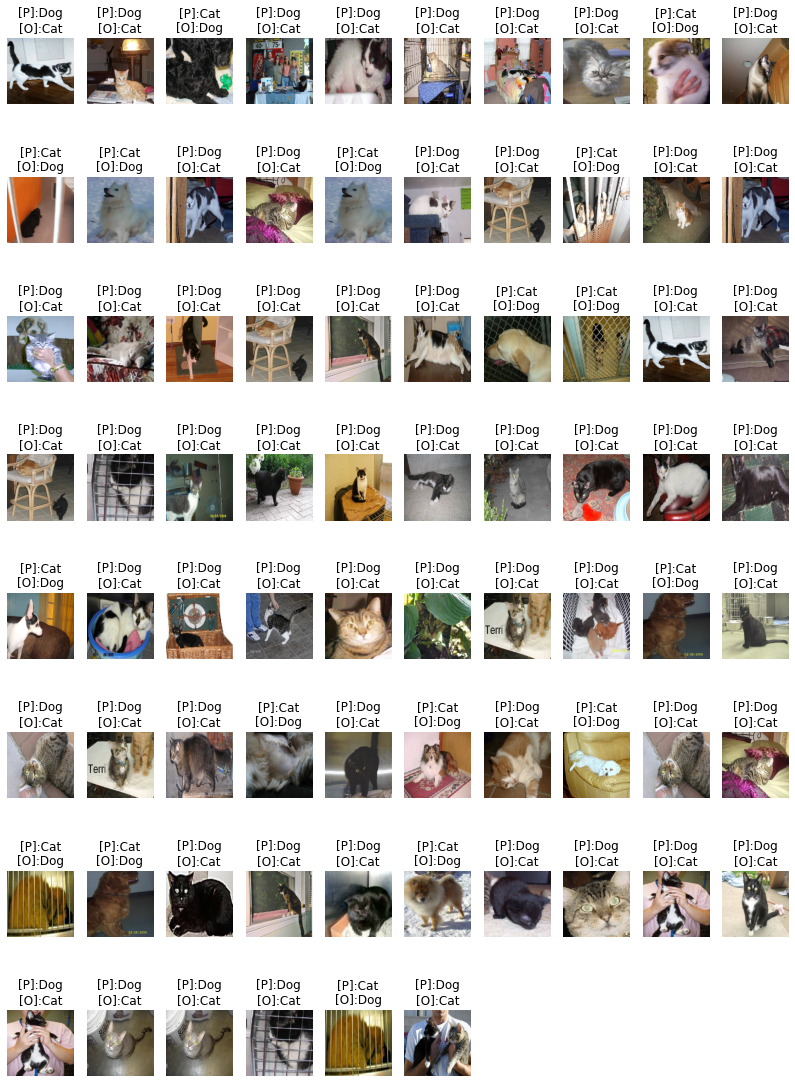

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
# [:200]: 太多錯, 我只取前兩百個
names = ["Cat", "Dog"]
idx = np.nonzero(pre != ans)[0]
false_pre_img = raw[idx]
false_pre_label = ans[idx]
false_pre_predict = pre[idx]

width = 10
height = len(idx) // width + 1
plt.figure(figsize=(14, 20))
for i, img in enumerate(false_pre_img):
    plt.subplot(height, width, i+1)
    t = "[P]:{}\n[O]:{}".format(names[false_pre_predict[i]],
                                names[false_pre_label[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)